In [1]:
import keras
from keras.api.models import Model
from keras.api.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.src.backend.common.keras_tensor import KerasTensor
from keras.api.optimizers import Adam
from keras.api.layers import Concatenate
from keras.api.losses import binary_focal_crossentropy
from keras.api.metrics import BinaryIoU
from keras.api.backend import clear_session
from torch.cuda import empty_cache
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
SIZE = 256
keras.backend.backend()

'torch'

# Load Data

In [3]:
train_fraction = .8

train_image_paths = sorted(glob.glob('dataset/train/*.png'))
train_masks_paths = sorted(glob.glob('dataset/trainannot/*.png'))
validation_image_paths = sorted(glob.glob('dataset/val/*.png'))
validation_masks_paths = sorted(glob.glob('dataset/valannot/*.png'))

def load_images(image_paths: list[str], size=256) -> np.ndarray:
	images_data = np.array([cv2.resize(cv2.imread(image_path)[:,:,::-1], (size, size)) for image_path in image_paths])
	images_data = images_data / 255
	return images_data

def load_masks(mask_paths: list[str], size=256) -> np.ndarray:
	masks_data = np.array([cv2.resize(cv2.imread(mask_path)[:,:,0], (size, size)) for mask_path in mask_paths])
	masks_data = np.where(masks_data==2, 0, 1)
	return masks_data

images = load_images(train_image_paths, SIZE)
masks = load_masks(train_masks_paths, SIZE)

train_images = images[:int(len(masks)*train_fraction)]
train_masks = masks[:int(len(masks)*train_fraction)]
validation_images = images[int(len(masks)*train_fraction):]
validation_masks = masks[int(len(masks)*train_fraction):]

# Unet Architecture

In [4]:
def convolution_block(previous_layer: KerasTensor, filters_n: int):
    convolution1 = Conv2D(filters_n, 3, activation='relu', padding='same')(previous_layer)
    convolution2 = Conv2D(filters_n, 3, activation='relu', padding='same')(convolution1)
    return convolution2


def encoder_block(previous_layer: KerasTensor, filters_n: int):
    conv = convolution_block(previous_layer, filters_n)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return pool, conv


def decoder_block(previous_layer: KerasTensor, skip_layer: KerasTensor, filters_n: int):
    upscale = Conv2DTranspose(filters_n, (2, 2), strides=2, padding='same')(previous_layer)
    concat = Concatenate()([upscale, skip_layer])
    conv = convolution_block(concat, filters_n)
    return conv


def create_model():
    inputs = Input((SIZE, SIZE, 3))
    encoder1, conv1 = encoder_block(inputs, 64)
    encoder2, conv2 = encoder_block(encoder1, 128)
    encoder3, conv3 = encoder_block(encoder2, 256)
    encoder4, conv4 = encoder_block(encoder3, 512)

    bridge = convolution_block(encoder4, 1024)

    decoder1 = decoder_block(bridge, conv4, 512)
    decoder2 = decoder_block(decoder1, conv3, 256)
    decoder3 = decoder_block(decoder2, conv2, 128)
    decoder4 = decoder_block(decoder3, conv1, 64)

    output = Conv2D(1, 1, activation='sigmoid', padding='same')(decoder4)

    return Model(inputs=inputs, outputs=output)

In [5]:
param_grid = {
	'epochs': [10, 40, 60, 100],
	'learning_rates': [0.01, 0.005, 0.001],
	'batch_size': [2, 5, 9]  # The maximum batch size that fits in my GPU
}

In [6]:
result = {}

In [7]:
for epochs in param_grid['epochs']:
	for learning_rate in param_grid['learning_rates']:
		for batch_size in param_grid['batch_size']:
			if (epochs, learning_rate, batch_size) in result:
				continue
			model = create_model()
			print(id(model))
			model.compile(optimizer=Adam(learning_rate=learning_rate), loss=binary_focal_crossentropy, metrics=['accuracy'])
			model.fit(train_images, train_masks, epochs=epochs, batch_size=batch_size, validation_split=0.2)
			model.compile(optimizer=Adam(learning_rate=learning_rate), loss=binary_focal_crossentropy, metrics=[BinaryIoU])
			metric_value = model.evaluate(validation_images, validation_masks, batch_size=8)
			result[(epochs, learning_rate, batch_size)] = metric_value
			del model
			clear_session()
			empty_cache()

140182216429776
Epoch 1/10


/usr/local/lib/python3.12/site-packages/keras/src/backend/torch/nn.py:402: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  outputs = tnn.conv2d(


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9823 - loss: 0.1761 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9904 - loss: 0.1550 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.9883 - loss: 0.1884 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9875 - loss: 0.2010 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9882 - loss: 0.1897 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9878 - loss: 0.1964 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9878 - loss: 0.1968 - val_accuracy: 0.9894 - val_loss: 0.1704
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9887 - loss: 0.1828 - val_accuracy: 0.9894 - val

In [9]:
result

{(10, 0.01, 2): [0.16313447058200836, 0.494939386844635],
 (10, 0.01, 5): [0.16313447058200836, 0.494939386844635],
 (10, 0.01, 9): [0.16313447058200836, 0.494939386844635],
 (10, 0.005, 2): [0.16313447058200836, 0.494939386844635],
 (10, 0.005, 5): [0.16313447058200836, 0.494939386844635],
 (10, 0.005, 9): [0.16313447058200836, 0.494939386844635],
 (10, 0.001, 2): [0.015757493674755096, 0.494939386844635],
 (10, 0.001, 5): [0.016162555664777756, 0.494939386844635],
 (10, 0.001, 9): [0.016975553706288338, 0.494939386844635],
 (40, 0.01, 2): [0.16313447058200836, 0.494939386844635],
 (40, 0.01, 5): [0.16313447058200836, 0.494939386844635],
 (40, 0.01, 9): [0.16313447058200836, 0.494939386844635],
 (40, 0.005, 2): [0.16313447058200836, 0.494939386844635],
 (40, 0.005, 5): [0.16313447058200836, 0.494939386844635],
 (40, 0.005, 9): [0.16313447058200836, 0.494939386844635],
 (40, 0.001, 2): [0.015823692083358765, 0.494939386844635],
 (40, 0.001, 5): [0.01602354645729065, 0.49554944038391113

## The best hyperparameters according to IoU: (40, 0.001, 9)

In [10]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_focal_crossentropy, metrics=['accuracy'])
history = model.fit(train_images, train_masks, epochs=40, batch_size=9, validation_split=0.2)

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 656ms/step - accuracy: 0.9756 - loss: 0.0838 - val_accuracy: 0.9894 - val_loss: 0.0323
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.9885 - loss: 0.0276 - val_accuracy: 0.9894 - val_loss: 0.0173
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 664ms/step - accuracy: 0.9881 - loss: 0.0183 - val_accuracy: 0.9894 - val_loss: 0.0161
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.9872 - loss: 0.0200 - val_accuracy: 0.9894 - val_loss: 0.0172
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.9884 - loss: 0.0164 - val_accuracy: 0.9894 - val_loss: 0.0180
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step - accuracy: 0.9888 - loss: 0.0148 - val_accuracy: 0.9894 - val_loss: 0.0200
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step - accuracy: 0.9890 - loss: 0.0152 - val_accuracy: 0.9894 - val_loss: 0.0164
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 659ms/step - accuracy: 0.9894 - loss: 0.0138 - val_accuracy: 0.

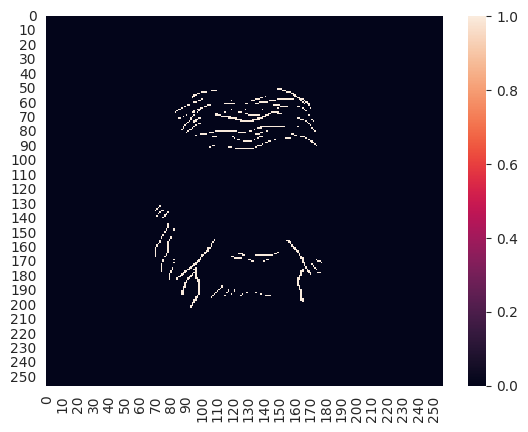

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


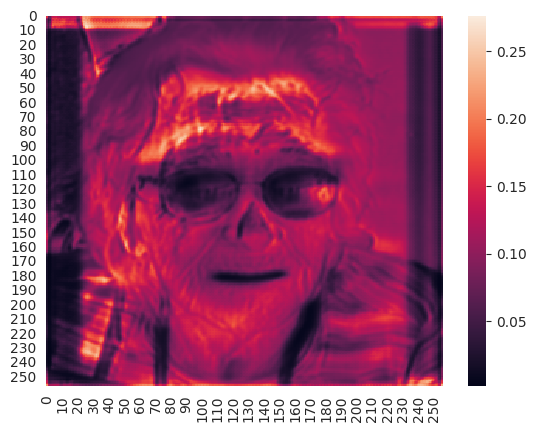

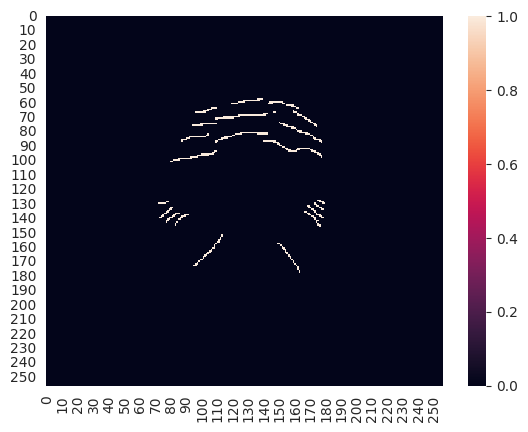

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


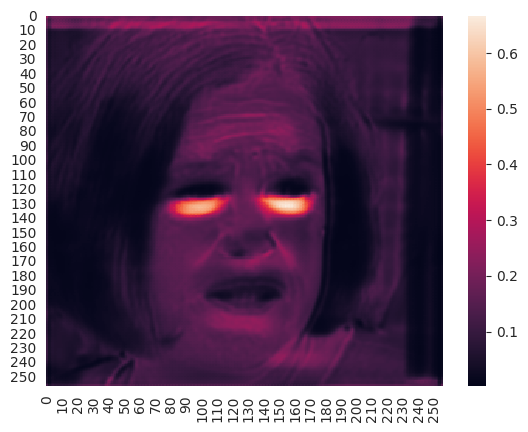

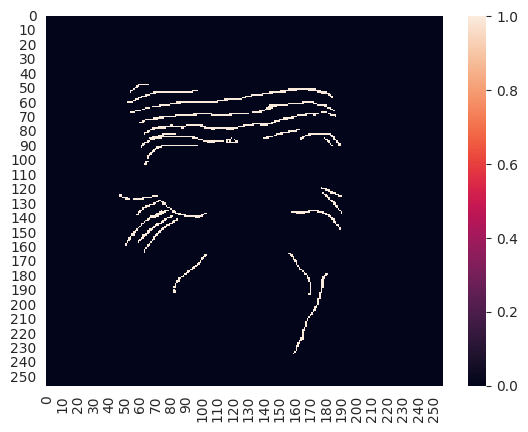

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


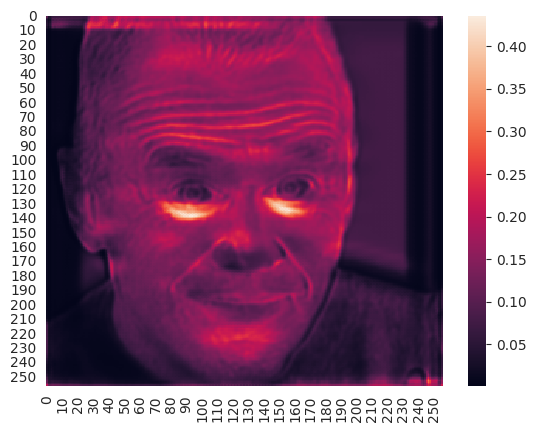

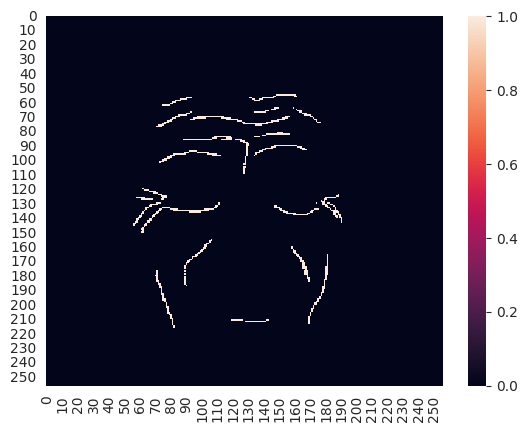

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


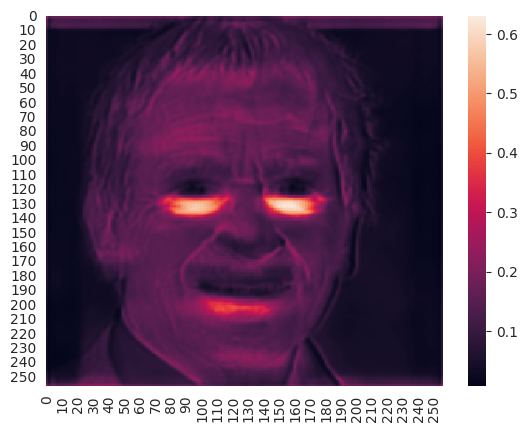

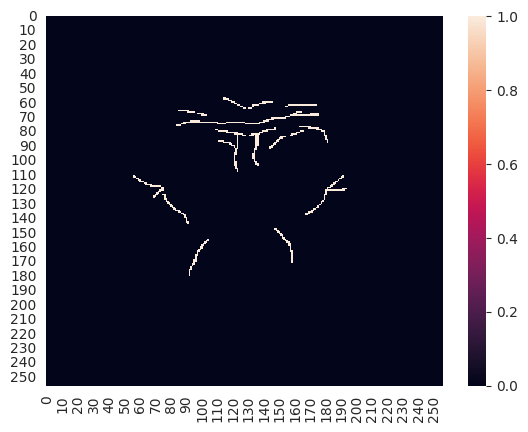

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


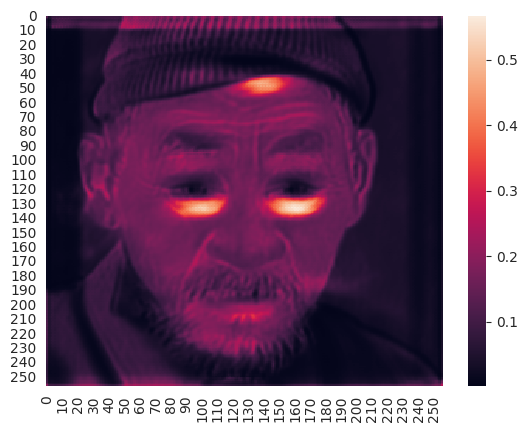

In [11]:
for i in range(len(validation_masks[:5])):
	sns.heatmap(validation_masks[i])
	plt.show()
	sns.heatmap(model.predict(validation_images[i:i+1])[0, :, :, 0])
	plt.show()

In [12]:
model.save('model.keras')

2024-09-12 21:07:12.885885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 21:07:13.085794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 21:07:13.885734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
